In [2]:
import torch
if not torch.cuda.is_available():
    raise RuntimeError("CUDA not available")

from PIL import Image
from torchvist as pltion import transforms
import matplotlib.pyplo

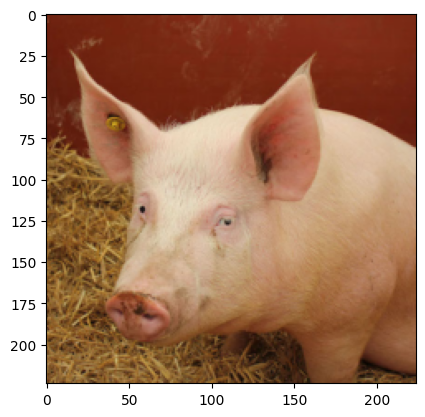

In [3]:
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
    transforms.Resize(224), # 224x224 is the common size for Google ImageNet
    transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None, :, :, :]
plt.imshow(pig_tensor[0].numpy().transpose(1, 2, 0))

#### - `ToTensor`
`torchvision.transforms.ToTensor()` is a function in the PyTorch library that converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]. 

#### - `[None, :, :, :]`
The `None` is used to add an extra dimension to the start of the tensor, creating a batch of a single image. 
> "all inputs to modules should be of the form batch_size x num_channels x height x width"

#### - PyTorch Tensor vs. Numpy Array
PyTorch tensors and numpy arrays are both multi-dimensional arrays, but they have some key differences:

1. **Device Compatibility**: PyTorch tensors can be moved to GPU for faster computations, while numpy arrays only operate on CPU.

2. **Automatic Differentiation**: PyTorch tensors support automatic differentiation and gradient computation, which are essential for training neural networks. Numpy does not have this feature.

3. **Tensor Operations**: PyTorch provides a wide range of operations specifically designed for tensor computations, many of which are not available in numpy.

4. **Data Types**: Both PyTorch tensors and numpy arrays support various data types, but the naming conventions are different. For example, a 64-bit integer is `torch.int64` in PyTorch and `numpy.int64` in numpy.

5. **Memory Sharing**: PyTorch tensors can share the same memory under certain conditions for efficient computing, while numpy arrays cannot.

6. **Interoperability**: PyTorch tensors can be easily converted to numpy arrays and vice versa, but note that PyTorch tensors on GPU need to be moved to CPU before converting to numpy arrays.

In the context of the provided code, the PyTorch tensor is converted to a numpy array for visualization with matplotlib, which operates on numpy arrays.

In [4]:
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights # pretrained 50-layer ResNet


In [5]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
        
    def forward(self, x):
        return (x - self.mean.type_as(x)[None, :, None, None]) / self.std.type_as(x)[None, :, None, None]
    
# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.eval();
pred = model(norm(pig_tensor))

#### - `[None, :, None, None]` Reshape
The effect of `[None, :, None, None]` is to reshape the mean and standard deviation tensors from a shape of `[num_cannels]`, in this case `[3]`, to a shape of `[1, num_channels, 1, 1]`. This matches the shape of the input tensor `x`, which is expected to have a shape of `[batch_size, num_channels, height, width]`. This allows for the subtraction and division operations to be performed correctly.
#### - Normalization
Normalization by subtracting the mean and dividing by the standard deviation is a common technique in statistics known as standardization or Z-score normalization.

The purpose of this technique is to transform the data to have zero mean and unit variance. Here's why:

1. **Zero Mean**: By subtracting the mean of the data, we ensure that the data is centered around zero. This can help remove any bias in the data due to the mean. For example, if we're dealing with images, different lighting conditions could result in different means. By centering the data, we remove this effect.

2. **Unit Variance**: By dividing by the standard deviation, we scale the data so that it has a standard deviation of 1. This ensures that all features have the same scale. This is important in machine learning because many algorithms are sensitive to the scale of the features. For example, in gradient descent, features with larger scales can dominate the updates to the model parameters.

In the context of the provided code, the normalization is performed on the input images before they are passed to the model. The mean and standard deviation values used are standard values for ImageNet images. By using these values, the normalization ensures that the model receives input data in the same format as the data it was originally trained on.
#### - `eval()`
The `.eval()` method in PyTorch is used to set the model to evaluation mode. This has any effect only on certain modules. For example, Dropout layers will not drop activations and BatchNorm layers will use running estimates instead of batch statistics. 

This is important because these behaviors are desirable during training, but not during testing and model evaluation. During testing, we want the model to use its learned parameters as is, without any randomness or additional computation introduced by these layers.

#### - `weights=ResNet50_Weights.DEFAULT`
`pretrained=true` might be depracated in future versions. Instead, we can import and load weights using
```python
from torchvision.models import resnet50, ResNet50_Weights
resnet50(weights=ResNet50_Weights.DEFAULT)
```

In [6]:
import json

with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

hog


#### - `dim=1`
`pred.max(dim=1)` is computing the maximum value along the second dimension (columns) of the `pred` tensor. This is typically used when `pred` is a batch of predictions, one for each input image, and each prediction is a vector of scores, one for each class. `max(dim=1)` then returns the maximum score and its corresponding class for each prediction in the batch.

The `[1]` after `max(dim=1)` is used to select the indices of the maximum values (i.e., the predicted classes), and `item()` is used to get the value as a standard Python number, assuming that there is only one image in the batch. This value is then used to look up the class name in the `imagenet_classes` dictionary.

In [9]:
import torch.optim as optim
epsilon = 2.0 / 255.0

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt= optim.SGD([delta], lr=1e-1)
hog_index = 341 # "hog" class in ImageNet

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([hog_index]))
    if t % 5 == 0:
        print(t, loss.item())
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0, hog_index].item())

0 -1.2798794507980347
5 -5.104941368103027
10 -4.88861083984375
15 -5.9905595779418945
20 -6.212702751159668
25 -5.910648822784424
True class probability: 0.0036111793015152216


#### - `lr=1e-1`
Set the learning rate of the optimizer to 0.1

#### - Projected Gradient Descent
1. `opt.zero_grad()`: This line resets the gradients of the model parameters to zero. By default, PyTorch accumulates gradients, i.e., the gradient computed by `backward()` is added to any existing gradient. To ensure that the computation of the gradient in the current step does not get influenced by the gradients computed in the previous steps, we need to zero out the gradients at the start of each step.

2. `loss.backward()`: This line computes the gradient of the loss with respect to the model parameters. This is done using backpropagation: starting from the loss, the gradient of each parameter is computed with respect to the loss, and stored in the `.grad` attribute of the parameter.

3. `opt.step()`: This line updates the model parameters using the gradients computed by `backward()`. The specific way in which the parameters are updated depends on the optimization algorithm used. For example, in stochastic gradient descent (SGD), each parameter is updated by subtracting the gradient of the parameter times the learning rate.
##### - How loss compute gradient on delta?
1. **Tensor Creation**: `delta` is created with `torch.zeros_like(pig_tensor, requires_grad=True)`. The `requires_grad=True` argument tells PyTorch to track all operations on `delta`. This means that PyTorch will be able to compute gradients with respect to `delta`.

2. **Loss Calculation**: The loss is calculated with `loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([hog_index]))`. Here, `pred` is computed as `model(norm(pig_tensor + delta))`. Notice that `delta` is involved in the computation of `pred`, and therefore in the computation of `loss`. In PyTorch tensors, the computational graph is preserved, meaning that even though `delta` and `pig_tensor` are added together, PyTorch remembers that the new tensor was created from `delta` and `pig_tensor`.

3. **Backward Propagation**: When `loss.backward()` is called, PyTorch computes the gradients of `loss` with respect to all tensors involved in its computation that have `requires_grad=True`. In this case, `delta` is the only such tensor, so PyTorch computes the gradient of `loss` with respect to `delta`.

4. **Gradient Storage**: The gradient computed in the previous step is stored in the `.grad` attribute of `delta`.

Predicted class:  rain_barrel
Predicted probability: 0.00913945771753788


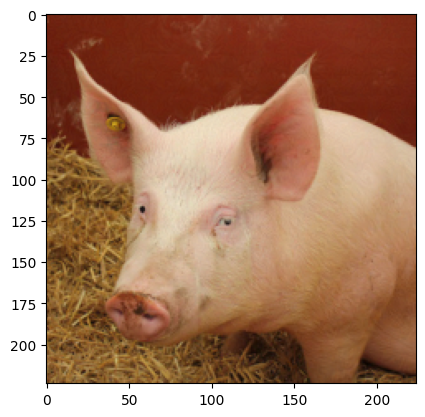

In [11]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1, 2, 0))

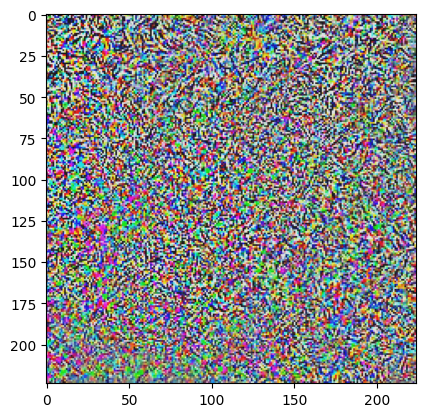

In [12]:
plt.imshow((delta * 50+0.5)[0].detach().numpy().transpose(1, 2, 0))

#### - Detach
The `detach()` method is used to detach the tensor from the computation graph. When you perform operations on tensors in PyTorch, PyTorch builds a computation graph that keeps track of the operations and allows the computation of gradients. If a tensor is part of a computation graph, and you try to convert it to a numpy array, you will get an error, because numpy does not support computation graphs or automatic differentiation. By calling `detach()`, you create a tensor that shares the same data, but is not part of the computation graph, and can be safely converted to a numpy array.

In [13]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(pig_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 5.919196128845215
10 2.575136423110962
20 0.14735031127929688
30 -4.103261470794678
40 -6.157636642456055
50 -8.367866516113281
60 -11.468094825744629
70 -10.830906867980957
80 -13.612140655517578
90 -14.152037620544434


In [14]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  airliner
Predicted probability: 0.9647517204284668


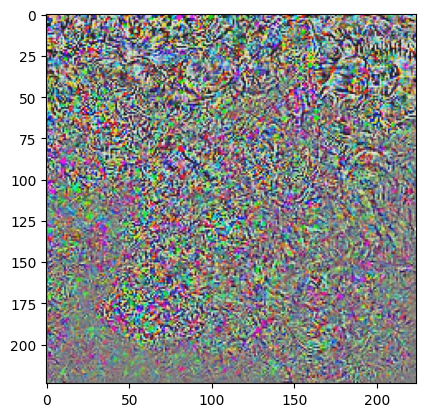

In [15]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))